In [1]:
!pip install biopython
!pip install dmslogo
!pip install pyBigWig

from google.colab import output
output.clear()

In [2]:
from google.colab import output
output.enable_custom_widget_manager()

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import to_rgba
import gzip
from functools import partial
import ast
import dmslogo
import random

import arviz as az
import seaborn as sns
import scipy.stats as stats
from scipy.ndimage import gaussian_filter1d

import Bio
from Bio import motifs
from operator import itemgetter

import torch
import torch.nn.functional as F

from tqdm.notebook import tqdm

import h5py
import pyBigWig

pd.set_option('display.max_columns', None)

if torch.cuda.is_available():
    use_cuda = True
    torch.backends.cudnn.benchmark = True
    print(f'GPU available: {torch.cuda.get_device_name(0)} ({torch.cuda.device_count()} count)')
else:
    print('No GPU available')

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

No GPU available


In [3]:
def tensor_to_pandas(in_tensor, tokens=['A', 'C', 'G', 'T'], colors=['green','orange','red','blue']):
    data = []
    my_array = in_tensor.cpu().numpy()
    for nt, score_vec,color in zip(tokens,[ sub_a for sub_a in my_array ],colors):
         _ = [ data.append([j,nt,score,color]) for j,score in enumerate(score_vec) ]
    return pd.DataFrame(data=data,columns=['site', 'letter', 'height','color'])

def matrix_to_dms(in_tensor, ax=None, y_max=2, fontaspect=.55, widthscale=0.8,
                  axisfontscale=0.6, heightscale=0.8, colors=['green','blue','orange','red']):
    motif = tensor_to_pandas(in_tensor, colors=colors)
    fig, ax = dmslogo.draw_logo(data=motif,
                                x_col='site',
                                letter_col='letter',
                                letter_height_col='height',
                                color_col='color',
                                ax=ax,
                                fixed_ymax=y_max,
                                fontaspect=fontaspect,
                                widthscale=widthscale,
                                axisfontscale=axisfontscale,
                                heightscale=heightscale)
    return fig, ax

def dna2tensor(sequence_str, vocab_list=['A', 'C', 'G', 'T']):
    seq_tensor = np.zeros((len(vocab_list), len(sequence_str)))
    for letterIdx, letter in enumerate(sequence_str):
        seq_tensor[vocab_list.index(letter), letterIdx] = 1
    seq_tensor = torch.Tensor(seq_tensor)
    return seq_tensor


cell_types = ['K562', 'HepG2', 'SKNSH']

# GATA locus

In [4]:
#--- Load DHS & H3k27ac
dhs_bw = pyBigWig.open('/content/drive/MyDrive/data/Genome_contributions/ENCFF414OGC_dhs.bigWig')
h3_bw = pyBigWig.open('/content/drive/MyDrive/data/Genome_contributions/ENCFF849TDM_h3k27ac.bigWig')

In [5]:
chr = 'X'
cell_idx = 0

cell_type = cell_types[cell_idx]

contrib_file = f'/content/drive/MyDrive/data/Genome_contributions/contrib__chr{chr}__{cell_type}.bw'
contrib_bw = pyBigWig.open(contrib_file)

mpra_preds = pyBigWig.open('/content/drive/MyDrive/data/Genome_contributions/50bp_scored_K562.bw')
gata_mpra = pyBigWig.open('/content/drive/MyDrive/data/Genome_contributions/GATA_MPRA.bw')

chrX:48000001-49000000


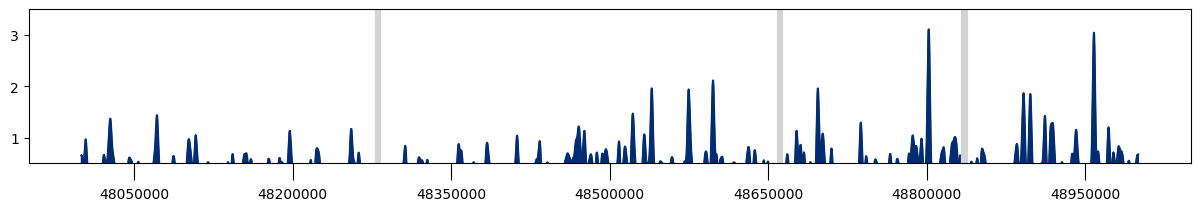

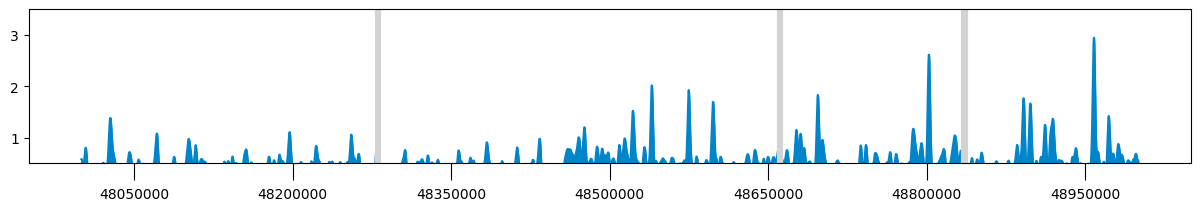

In [6]:
# random_start = 47644550 + 500000 #150000
# random_stop = 49644949 - 500000

# random_start = 48145000
# random_stop = 49145000

random_start = 48000000
random_stop = 49000000

sigma = 1000
figsize = (15, 2)
tick_fontsize = 10

color_dict = {'#002D72': 'MPRA', '#0085CA': 'Malinois'}

pos = f'chr{chr}:{random_start + 1}-{random_stop}'
print(pos)
dhs_scores = dhs_bw.values(f'chr{chr}', random_start, random_stop)
h3_scores = h3_bw.values(f'chr{chr}', random_start, random_stop)
contrib_scores = contrib_bw.values(f'chr{chr}', random_start, random_stop)
mpra_scores = gata_mpra.values(f'chr{chr}', random_start, random_stop)
pred_scores = mpra_preds.values(f'chr{chr}', random_start, random_stop)

#--- Shade regions with no data ---
where_nan = np.where(np.isnan(np.array(mpra_scores)))[0]
ranges = []
ini_point = 0
for i in range(0, len(where_nan) - 1):
    jump = where_nan[i+1] - where_nan[i]
    if jump > 1:
        ranges.append([ini_point, i])
        ini_point = i + 1
ranges.append([ini_point, i])
no_data_regions = [(where_nan[range[0]], where_nan[range[1]]) for range in ranges]

score_list = [mpra_scores, pred_scores]
plot_colors = list(color_dict.keys())
for scores, color in zip(score_list, plot_colors):
    fig, ax = plt.subplots(figsize=figsize)
    T = np.arange(0, random_stop-random_start)
    ysmoothed = gaussian_filter1d(scores, sigma=sigma)
    ax.plot(T, ysmoothed, color=color, label='MPRA tiling', rasterized=False)
    ax.fill_between(range(len(ysmoothed)), ysmoothed, alpha=1, color=color, rasterized=True)
    #plt.ylabel('log2(FoldChange)', fontsize=16, labelpad=10)
    plt.ylim(0.5, 3.5)

    xtick_offset = 50000
    xtick_stride = 150000
    xticks = list(range(xtick_offset, random_stop - random_start, xtick_stride))
    xtick_labels = list(range(random_start + xtick_offset, random_stop, xtick_stride))
    plt.xticks(xticks, labels=xtick_labels, rotation=0, fontsize=tick_fontsize)

    for no_data_region in no_data_regions:
        plt.vlines(no_data_region[0] - 1000, 0, 5, linewidth=3, color='lightgray')
        plt.vlines(no_data_region[1] + 1000, 0, 5, linewidth=3, color='lightgray')
        #ax.axvspan(no_data_region[0] - 2000, no_data_region[1] + 2000, color='red', alpha=0.5)
    # ax.spines['left'].set_position(('outward', 15))
    # ax.spines['left'].set_visible(False)
    # ax.spines['bottom'].set_visible(False)
    # ax.spines['top'].set_visible(False)
    # ax.spines['right'].set_visible(False)
    ax.tick_params(axis='x', which='major', pad=5, length=12)#, colors='#002D72')
    #plt.yticks([0, 1, 2], fontsize=16)
    #plt.yticks([])
    savepath = f'/content/drive/MyDrive/figures/genome_contributions/{pos}_gata_locus_track_K562_{color_dict[color]}_boda_paper_v2.pdf'
    #plt.savefig(savepath, format='pdf', transparent=True, dpi=200, bbox_inches='tight')
    plt.show()

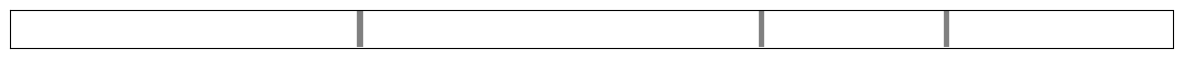

In [8]:
fig, ax = plt.subplots(figsize=(15, 0.5))
T = np.arange(0, random_stop-random_start)
zeros = np.zeros_like(T)
ax.plot(T, zeros, color='white', rasterized=False)

plt.ylim(0, 1)
xtick_offset = 50000
xtick_stride = 150000
xticks = list(range(xtick_offset, random_stop - random_start, xtick_stride))
xtick_labels = list(range(random_start + xtick_offset, random_stop, xtick_stride))
plt.xticks(xticks, labels=xtick_labels, rotation=0, fontsize=tick_fontsize)
for no_data_region in no_data_regions:
    # plt.vlines(no_data_region[0] - 1000, 0, 5, linewidth=3, color='lightgray')
    # plt.vlines(no_data_region[1] + 1000, 0, 5, linewidth=3, color='lightgray')
    ax.axvspan(no_data_region[0] - 2000, no_data_region[1] + 2000, color='gray')
ax.tick_params(axis='x', which='major', pad=5, length=12)#, colors='#002D72')
plt.xticks([])
plt.yticks([])
savepath = f'/content/drive/MyDrive/figures/genome_contributions/{pos}_gata_locus_track_K562_experimental_dropouts.pdf'
plt.savefig(savepath, format='pdf', transparent=True, dpi=200, bbox_inches='tight')
plt.show()

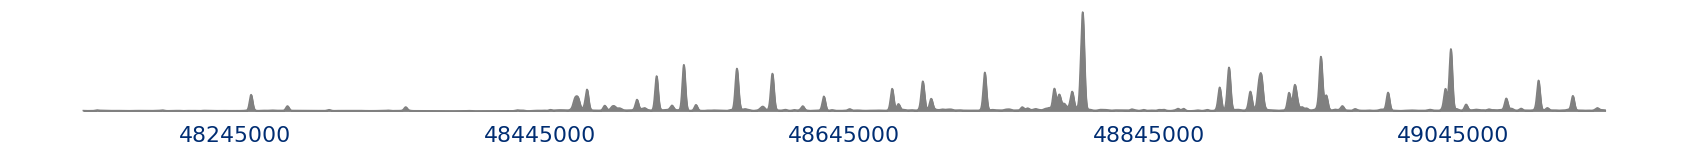

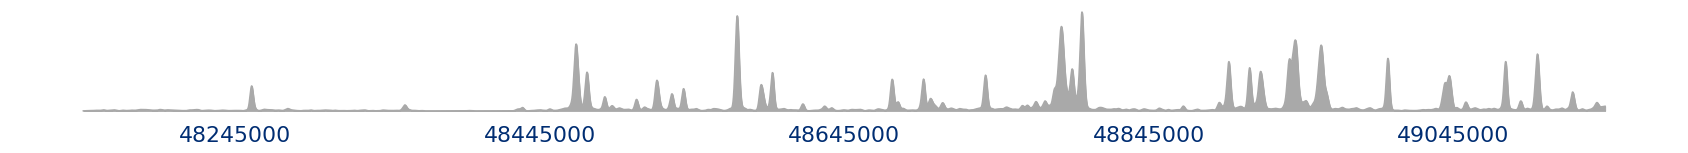

In [ ]:
sigma = 1000
color_dict = {'grey': 'DHS', 'darkgrey': 'H3K27ac'}

score_list = [dhs_scores, h3_scores]
plot_colors = list(color_dict.keys())
for scores, color in zip(score_list, plot_colors):
    fig, ax = plt.subplots(figsize=figsize)
    T = np.arange(0, random_stop-random_start)
    ysmoothed = gaussian_filter1d(scores, sigma=sigma)
    ax.plot(T, ysmoothed, color=color, label='MPRA tiling')
    ax.fill_between(range(len(ysmoothed)), ysmoothed, alpha=1, color=color)
    #plt.ylabel('log2(FoldChange)', fontsize=16, labelpad=10)
    #plt.ylim(0.5, 3)

    xticks = list(range(xtick_offset, random_stop - random_start, 200000))
    xtick_labels = list(range(random_start + xtick_offset, random_stop, 200000))
    plt.xticks(xticks, labels=xtick_labels, rotation=0, fontsize=tick_fontsize)
    #ax.spines['left'].set_position(('outward', 15))
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='x', which='major', pad=10, length=0, colors='#002D72')#, labelbottom=False, labeltop=True)
    #plt.yticks([0, 1, 2], fontsize=16)
    plt.yticks([])
    # savepath = f'/content/drive/MyDrive/figures/genome_contributions/{pos}_gata_locus_track_K562_{color_dict[color]}.png'
    # plt.savefig(savepath, format='png', transparent=True, dpi=200, bbox_inches='tight')
    plt.show()

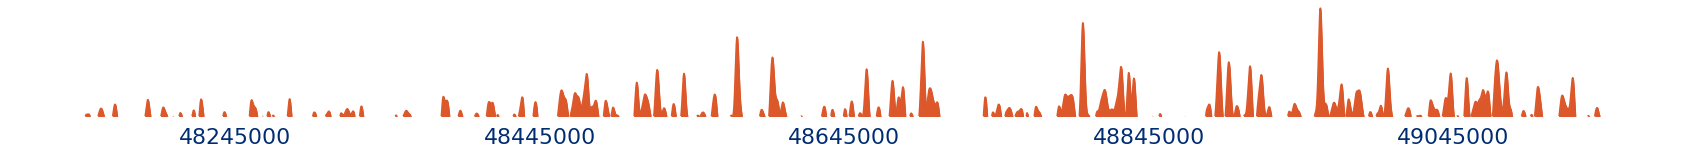

In [ ]:
sigma = 1000
color_dict = {'#DC582A': 'contributions'}

score_list = [contrib_scores]
plot_colors = list(color_dict.keys())
for scores, color in zip(score_list, plot_colors):
    fig, ax = plt.subplots(figsize=figsize)
    T = np.arange(0, random_stop-random_start)
    ysmoothed = gaussian_filter1d(scores, sigma=sigma)
    ax.plot(T, ysmoothed, color=color, label='MPRA tiling')
    ax.fill_between(range(len(ysmoothed)), ysmoothed, alpha=1, color=color)
    #plt.ylabel('log2(FoldChange)', fontsize=16, labelpad=10)
    plt.ylim(0.008, 0.03)

    xticks = list(range(xtick_offset, random_stop - random_start, 200000))
    xtick_labels = list(range(random_start + xtick_offset, random_stop, 200000))
    plt.xticks(xticks, labels=xtick_labels, rotation=0, fontsize=tick_fontsize)
    #ax.spines['left'].set_position(('outward', 15))
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='x', which='major', pad=12, length=0, colors='#002D72')
    # for tick in ax.get_xticklabels():
    #     tick.set_fontname("Adobe Arabic")
    #plt.yticks([0, 1, 2], fontsize=16)
    plt.yticks([])
    # savepath = f'/content/drive/MyDrive/figures/genome_contributions/{pos}_gata_locus_track_K562_{color_dict[color]}.png'
    # plt.savefig(savepath, format='png', transparent=True, dpi=200, bbox_inches='tight')
    plt.show()

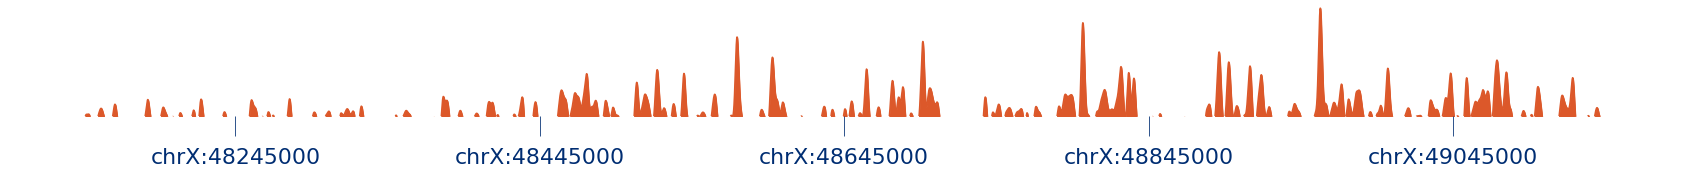

In [ ]:
sigma = 1000
color_dict = {'#DC582A': 'contributions'}

score_list = [contrib_scores]
plot_colors = list(color_dict.keys())
for scores, color in zip(score_list, plot_colors):
    fig, ax = plt.subplots(figsize=figsize)
    T = np.arange(0, random_stop-random_start)
    ysmoothed = gaussian_filter1d(scores, sigma=sigma)
    ax.plot(T, ysmoothed, color=color, label='MPRA tiling')
    ax.fill_between(range(len(ysmoothed)), ysmoothed, alpha=1, color=color)
    #plt.ylabel('log2(FoldChange)', fontsize=16, labelpad=10)
    plt.ylim(0.008, 0.03)

    xticks = list(range(xtick_offset, random_stop - random_start, 200000))
    xtick_labels = list(range(random_start + xtick_offset, random_stop, 200000))
    xtick_labels = [f'chrX:{pos}' for pos in xtick_labels]
    plt.xticks(xticks, labels=xtick_labels, rotation=0, fontsize=tick_fontsize)
    #ax.spines['left'].set_position(('outward', 15))
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='x', which='major', pad=12, length=20, colors='#002D72')
    # for tick in ax.get_xticklabels():
    #     tick.set_fontname("Adobe Arabic")
    #plt.yticks([0, 1, 2], fontsize=16)
    plt.yticks([])
    savepath = f'/content/drive/MyDrive/figures/genome_contributions/{pos}_gata_locus_track_K562_{color_dict[color]}_alt.png'
    plt.savefig(savepath, format='png', transparent=True, dpi=200, bbox_inches='tight')
    plt.show()

# Load saturation mutagenesis library

In [ ]:
#--- Load SatMut library

rootdir = '/content/drive/MyDrive/data/OL50_SatMut/results'

df_dict = {}
for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        filepath = subdir + os.sep + file
        if filepath.endswith(".out"):
            if ('Counts' not in filepath) and ('emVAR' not in filepath):
                file_begin_idx = filepath.find('results/OL') + len('results/OL') - 2
                file_name = filepath[file_begin_idx:]
                print(file_name)
                library_num_end_idx = file_name.find('_')
                library_num = file_name[2:library_num_end_idx]
                remaining_str = file_name[library_num_end_idx+1:]
                cell_name_end_idx = remaining_str.find('_')
                cell_name = remaining_str[:cell_name_end_idx]
                df_name = library_num + "_" + cell_name
                df_temp = pd.read_csv(filepath, sep="	", low_memory=False)
                df_temp['OL'] = library_num
                df_temp['celltype'] = cell_name.lower()
                df_dict[df_name] = df_temp

fasta_file_name = '/content/drive/MyDrive/data/OL50_SatMut/OL50.uncollapsed.fa'

fasta_dict = {}
with open(fasta_file_name, 'r') as f:
    for line in f:
        line_str = str(line)
        if line_str[0] == '>':
            my_id = line_str.lstrip('>').rstrip('\n')
            fasta_dict[my_id] = ''
        else:
            fasta_dict[my_id] += line_str.rstrip('\n')

OL50_HepG2_20230216.out
OL50_K562_20230216.out


In [ ]:
def plot_satmut(effect_array,
                colors       = ['g', 'b', 'C1', 'r'],
                figsize      = (50,5),
                stem_offset  = 0.0,
                marker_alpha = 0.5,
                stem_alpha   = 0.5,
                linestyle    = 'solid'):

    markerfmts = [color + '.' for color in colors]
    locs = np.arange(0, effect_array.shape[1])
    fig, ax = plt.subplots(figsize=figsize)

    offset = 0
    for i in range(4):
        heads = np.array(effect_array[i,:], copy=True)
        heads[heads == 0.] = np.nan
        markerline, stemlines, baseline = plt.stem(locs + offset, heads, 'k', markerfmt=markerfmts[i])
        plt.setp(stemlines, 'linestyle', linestyle)
        plt.setp(stemlines, 'alpha', stem_alpha)
        plt.setp(markerline, 'alpha', marker_alpha)
        plt.setp(baseline, 'color', 'k')
        plt.setp(baseline, 'alpha', 0.0)
        plt.setp(baseline, 'linestyle', 'dashed')

        offset += stem_offset

    plt.margins(x=0.0075)
    #plt.ylim(y_min, y_max)
    #plt.axis('off')
    plt.xticks([])
    #plt.box(False)
    plt.yticks(fontsize=18)
    ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # plt.ylabel('log2FC skew', fontsize=20)
    # plt.title(f'{parent_id}  {cell_type}', fontsize=32)
    return fig, ax


### Saturation mutagenesis comparison chr 7

In [ ]:
#!wget https://storage.googleapis.com/tewhey-public-data/contribution_scores_202212/HepG2/contrib__chr7__HepG2.bw
!wget https://storage.googleapis.com/tewhey-public-data/contribution_scores_202212/K562/contrib__chr7__K562.bw

--2023-03-15 23:00:21--  https://storage.googleapis.com/tewhey-public-data/contribution_scores_202212/K562/contrib__chr7__K562.bw
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.13.128, 74.125.134.128, 74.125.26.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.13.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1284809216 (1.2G) [application/octet-stream]
Saving to: ‘contrib__chr7__K562.bw’

contrib__chr7__K562 100%[===================>]   1.20G   189MB/s    in 7.2s    

2023-03-15 23:00:28 (169 MB/s) - ‘contrib__chr7__K562.bw’ saved [1284809216/1284809216]



In [ ]:
#contrib_bw = pyBigWig.open('contrib__chr7__HepG2.bw')
contrib_bw = pyBigWig.open('contrib__chr7__K562.bw')

In [ ]:
cell_type = 'K562' #K562 HepG2
cell_df = df_dict[f'50_{cell_type}']

genomic_df = cell_df[cell_df['project'] == 'UKBB-GTEx_Sat'].sort_values('sat_ref').reset_index(drop=True)
ref_flags = [True if x[4] == 'R' else False for x in genomic_df['sat_ref'].str.split(':').tolist()]
genomic_df = genomic_df[ref_flags].reset_index(drop=True)

if not bool(genomic_df[genomic_df['sat_mut'] == 'm0']['log2FoldChange'].isna().sum()):
    print('All good')

genomic_df['chr'] = [x[0] for x in genomic_df['ID'].str.split(':').tolist()]

All good


In [ ]:
chr_df = genomic_df[genomic_df['chr'] == '7']

parent_ids = chr_df['sat_ref'].unique()
parent_ids = [id for id in parent_ids if '_' not in id]
len(parent_ids)

7

In [ ]:
for parent_id in parent_ids:
    print(parent_id)
    print(fasta_dict[f'{parent_id}:m0'])
    print('')

7:105416560:C:A:R:wC
GTTTGGGAGATGCTTCTCTGCTTATGGCTCAGGATAGGGAGAATTCCGAGATGACCTTTTGAATCAGCGCTGCTAACATTCTTTACTCAGATTTAAATACAGGAATGTTTGTTACCCGAATTCTCCTCGGTGGATACAGCTCTGAGGAATGGAATGGAGCAGCCTGTATGGCAAGGACACACCAGTGATGAGTCAGAAGC

7:139875230:C:T:R:wC
TCTGGCCTGGTCTTGTAGTGTTTCTGTAAAATTGGGGAGGGGGGGAGCGGAGGCTGTATTTAAATGTCCTGCTGTCAATCAAAAGACACTTCCTACAATCACAGTCACCATATCTGCTATTACTCGTGAGCGTGCTCTCGCCAAGAGACAACACCAAACGGGGCCCGGGAAACCGGCTTCAACTAAAGGTGACCGCAGGC

7:27717716:G:C:R:wC
AGGGTACAAAGAAAAATCAGCAAAGGCAAAAGCACATGGAGCAAAGTCTAGAGGAAACCAAGCTCAAGCTTTTGATAATTCTTTCCAAATGAAGTCACAGAAGACACGCCTAACTCCTTAGTAATGAGTCATGATGACATGTGGGAAGTGTTTTCTACCAGAGAAGCTCATTATACACTCTGCACCCAGGGTTTTACTGG

7:28996557:C:T:R:wC
TCCAGGTATTTGCCTCGCAGGGCCGGGGGGTGGCGACACTGCACGAAGACAGTGAGGAGCCGGCCCTGCGAGTGCCAGTCGCCCATCCAGCGCTTCAGGCCTCGCAGCCGGCAGTCGCAGGTCCAGCCGTTGCCGTCTAGATCCAGCCGATAAAGGGCTGGGCTGGCGGCGAAGATGTCCCCGGATAGGGCGCTGAGCGC

7:77026460:G:A:R:wC
AAAAGAAAAAAAATCCATTAGCAATTGATCCATATGGTAGCTTGTTAAAGTTTACCAGTTTAAACCTGAAATAGATGAGGGCTCAAAGGA

In [ ]:
lift_dict = {'7:105416560:C:A:R:wC': 'chr7:105776015  105776214',
             '7:139875230:C:T:R:wC': 'chr7:140175331  140175530',
             '7:27717716:G:C:R:wC': 'chr7:27677998  27678197',
             '7:28996557:C:T:R:wC': 'chr7:28956842  28957041',
             '7:77026460:G:A:R:wC': 'chr7:77397044  77397243',
             '7:77169782:C:G:R:wC': 'chr7:77540366  77540565',
             '7:95070487:A:G:R:wC': 'chr7:95441076  95441275',
             }

7:105416560:C:A:R:wC


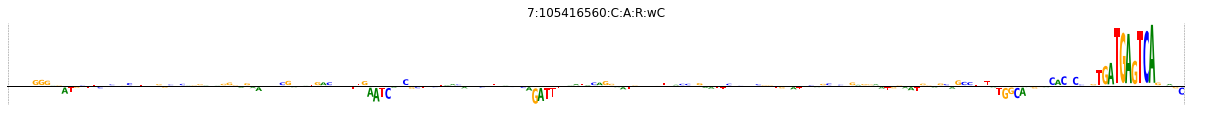

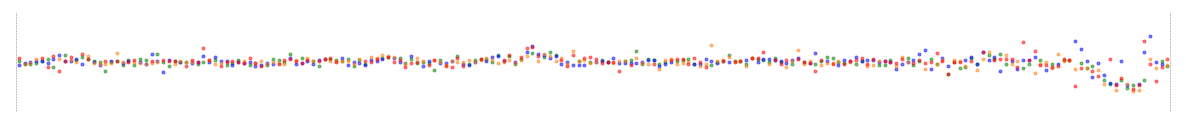


7:139875230:C:T:R:wC


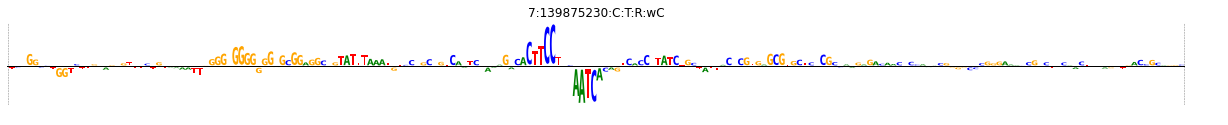

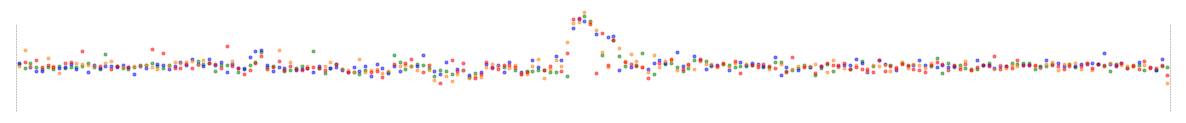


7:27717716:G:C:R:wC


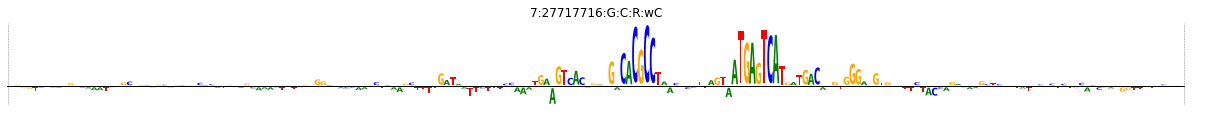

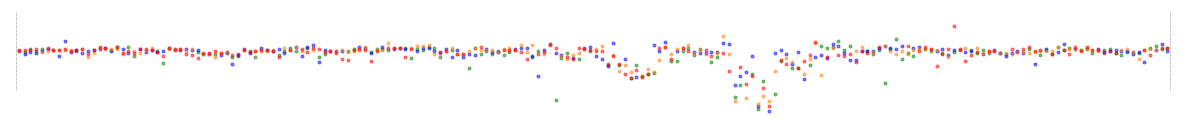


7:28996557:C:T:R:wC


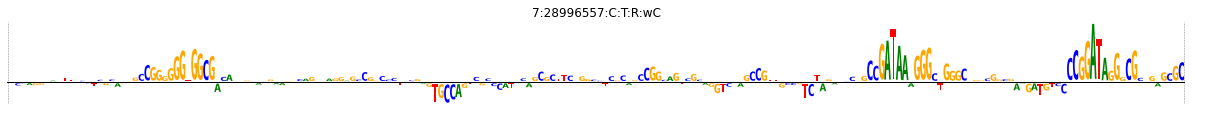

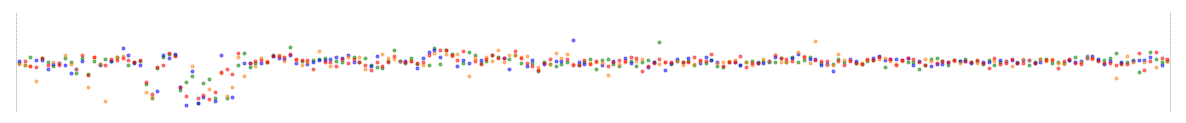


7:77026460:G:A:R:wC


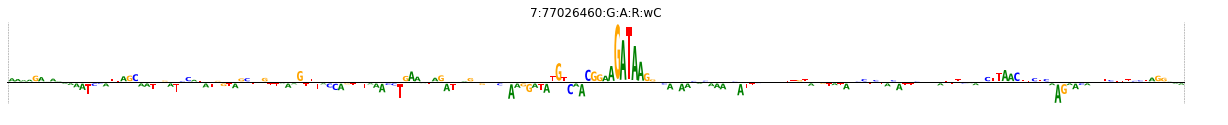

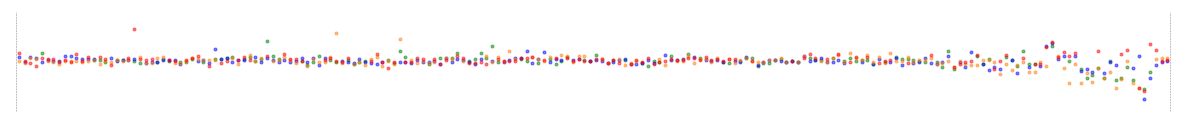


7:77169782:C:G:R:wC


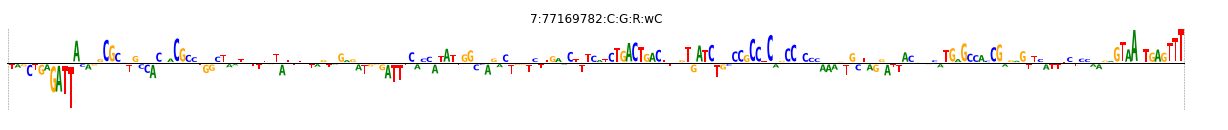

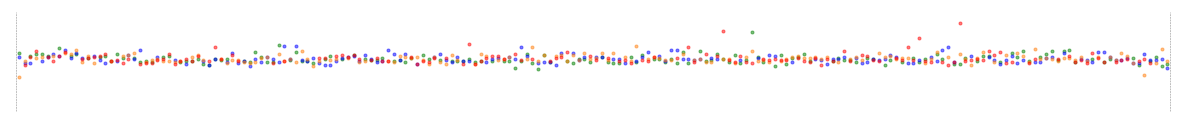


7:95070487:A:G:R:wC


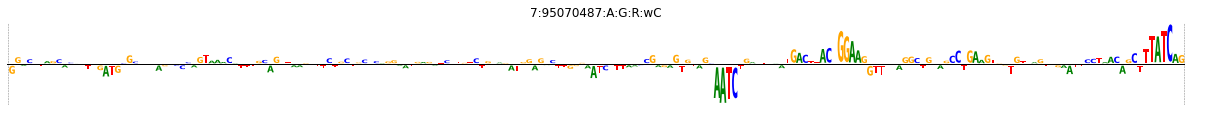

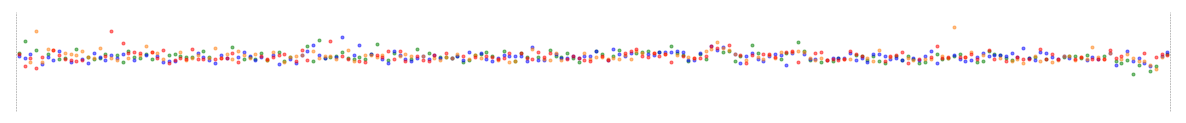

In [ ]:
chr = 7

#parent_ids = ['7:105416560:C:A:R:wC', '7:27717716:G:C:R:wC']
for parent_id in parent_ids:
    print(parent_id, flush=True)
    parent_seq = fasta_dict[f'{parent_id}:m0']
    lift_pos = lift_dict[parent_id]
    start, stop = lift_pos.split(':')[1].split('  ')
    start, stop = int(start) - 1, int(stop)

    #--- Contributions
    contributions = contrib_bw.values(f'chr{chr}', start, stop)
    seq_onehot = dna2tensor(parent_seq)
    seq_contributions = seq_onehot * torch.Tensor(contributions)

    title = f'chr{chr}:{start+1}-{stop}'
    #print(title)
    y_max = seq_contributions.max()
    fig, ax = matrix_to_dms(seq_contributions, y_max=y_max, fontaspect=0.5, widthscale=0.3, axisfontscale=0.6, heightscale=0.6)
    ax.vlines(0, -1, y_max, linestyles='dashed', color='k', alpha=0.5)
    ax.vlines(200, -1, y_max, linestyles='dashed', color='k', alpha=0.5)
    #ax.spines['left'].set_position(('outward', 20))
    #ax.spines['bottom'].set_visible(False)
    plt.axis('off')
    plt.xticks([])
    # plt.yticks([0, 0.5],  fontsize=12)
    plt.xlabel('')
    plt.ylabel('Contribution', fontsize=16)
    #plt.title(title)
    plt.title(parent_id)
    # savepath = f'/content/drive/MyDrive/figures/genome_contributions/{parent_id}_contributions_{cell_type}.pdf'
    # plt.savefig(savepath, format='pdf', transparent=True, dpi=500, bbox_inches='tight')
    #plt.savefig('temp_logo.pdf', format='pdf', transparent=True, dpi=50, bbox_inches='tight')
    plt.show()

    #--- SatMut
    family_df = genomic_df[genomic_df['sat_ref'] == parent_id].reset_index(drop=True)

    ref_df = family_df[family_df['sat_mut'] == 'm0'].reset_index(drop=True)
    alt_df = family_df[family_df['sat_mut'] != 'm0'].reset_index(drop=True)
    alt_df = alt_df[alt_df['log2FoldChange'].notnull()].reset_index(drop=True)

    ref_lfc = ref_df['log2FoldChange'].item()

    alphabet_dict = {'A': 0, 'C': 1, 'G': 2, 'T': 3}
    skew_array = np.zeros((4, 200))
    l2fc_array = np.zeros((4, 200))
    for i in range(len(alt_df)):
        single_alt_df = alt_df.iloc[i]
        pos_id = single_alt_df['sat_mut']
        pos_lfc = single_alt_df['log2FoldChange'].item()
        pos_skew = pos_lfc - ref_lfc
        pos_id = pos_id.lstrip('m')
        ref_nt, alt_nt = pos_id[0], pos_id[-1]
        pos = int(pos_id.lstrip(ref_nt).rstrip(alt_nt)) - 1
        skew_array[alphabet_dict[alt_nt], pos] = pos_skew
        l2fc_array[alphabet_dict[alt_nt], pos] = pos_lfc

    fig, ax = plot_satmut(skew_array, stem_alpha=0.0, figsize=(21, 2))
    ax.vlines(-0.5, -3, 3, linestyles='dashed', color='k', alpha=0.5)
    ax.vlines(199.5, -3, 3, linestyles='dashed', color='k', alpha=0.5)
    plt.axis('off')
    # savepath = f'/content/drive/MyDrive/figures/genome_contributions/{parent_id}_SatMut_{cell_type}.pdf'
    # plt.savefig(savepath, format='pdf', transparent=True, dpi=300, bbox_inches='tight')
    plt.show()
    print('')



### Saturation mutagenesis comparison chr 13

In [ ]:
#!wget https://storage.googleapis.com/tewhey-public-data/contribution_scores_202212/HepG2/contrib__chr13__HepG2.bw
!wget https://storage.googleapis.com/tewhey-public-data/contribution_scores_202212/K562/contrib__chr13__K562.bw

--2023-03-05 23:25:24--  https://storage.googleapis.com/tewhey-public-data/contribution_scores_202212/K562/contrib__chr13__K562.bw
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.214.128, 173.194.212.128, 173.194.213.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.214.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 839691816 (801M) [application/octet-stream]
Saving to: ‘contrib__chr13__K562.bw’

contrib__chr13__K56 100%[===================>] 800.79M   165MB/s    in 6.0s    

2023-03-05 23:25:30 (133 MB/s) - ‘contrib__chr13__K562.bw’ saved [839691816/839691816]



In [ ]:
#contrib_bw = pyBigWig.open('contrib__chr13__HepG2.bw')
contrib_bw = pyBigWig.open('contrib__chr13__K562.bw')

In [ ]:
cell_type = 'K562' #K562
cell_df = df_dict[f'50_{cell_type}']

genomic_df = cell_df[cell_df['project'] == 'UKBB-GTEx_Sat'].sort_values('sat_ref').reset_index(drop=True)
ref_flags = [True if x[4] == 'R' else False for x in genomic_df['sat_ref'].str.split(':').tolist()]
genomic_df = genomic_df[ref_flags].reset_index(drop=True)

if not bool(genomic_df[genomic_df['sat_mut'] == 'm0']['log2FoldChange'].isna().sum()):
    print('All good')

genomic_df['chr'] = [x[0] for x in genomic_df['ID'].str.split(':').tolist()]

All good


In [ ]:
chr_df = genomic_df[genomic_df['chr'] == '13']

parent_ids = chr_df['sat_ref'].unique()
parent_ids = [id for id in parent_ids if '_' not in id]
len(parent_ids)

2

In [ ]:
for parent_id in parent_ids:
    print(parent_id)
    print(fasta_dict[f'{parent_id}:m0'])
    print('')

13:44389479:T:G:R:wC
GGTTTGCAGGCTGGCTTATGGAGAGTCAGGGGTTAAGTGTTCTTCCAACTTTGCAAAAGATAAATCAGTCATCTACTAGGAAAAGAGGAAAATCAGAGATAAGCTGAAAGCATTCCTCTCATAATTTTCCATTCCTGGGGAGTAGATTTGACATTTTCTTCCCTTAATGGAAACATGAGTCATGAGGAATAAATGCTCCC

13:50432800:T:C:R:wC
AGGTATTACTGAGCAAATGTTCTCTTGAAAAACTTGATTTCTTCTTATGCTTGGAAATTTTGCTATAGAGATAGTCATTGCTACTGTTTACAGTAGACATTCCAACCCTGAAAACTAAACTCTGAAGTATTTACTATGCTTAGATAAATCACATATTTGTCCTCATGAGTACAGCCTGTTCAGGTTTGTACATACCATTG



In [ ]:
lift_dict = {'13:44389479:T:G:R:wC': 'chr13:43815244  43815443',
             '13:50432800:T:C:R:wC': 'chr13:49858565  49858764'
             }

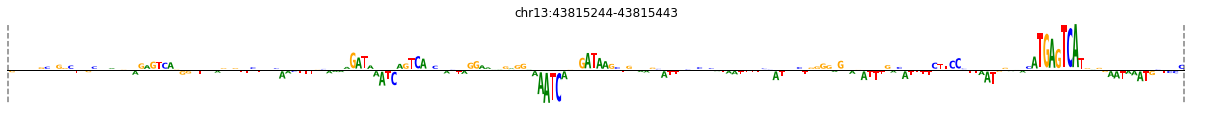

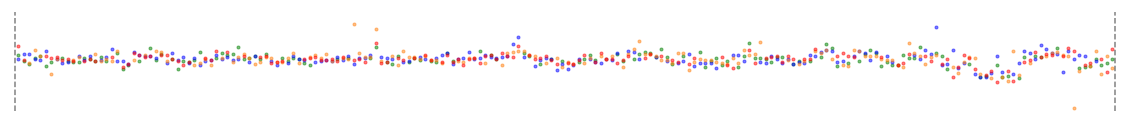

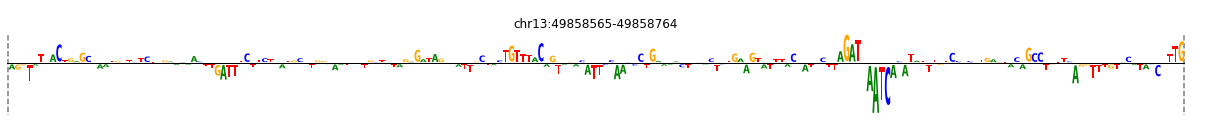

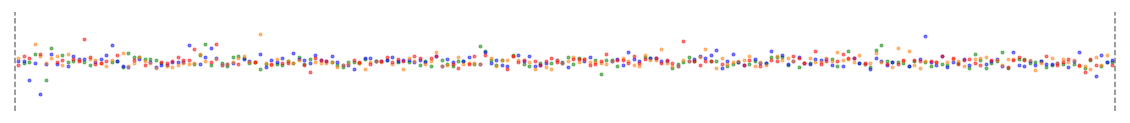

In [ ]:
chr = 13
for parent_id in parent_ids:
    parent_seq = fasta_dict[f'{parent_id}:m0']
    lift_pos = lift_dict[parent_id]
    start, stop = lift_pos.split(':')[1].split('  ')
    start, stop = int(start) - 1, int(stop)

    #--- Contributions
    contributions = contrib_bw.values(f'chr{chr}', start, stop)
    seq_onehot = dna2tensor(parent_seq)
    seq_contributions = seq_onehot * torch.Tensor(contributions)

    title = f'chr{chr}:{start+1}-{stop}'
    #print(title)
    y_max = seq_contributions.max()
    fig, ax = matrix_to_dms(seq_contributions, y_max=y_max, fontaspect=0.5, widthscale=0.3, axisfontscale=0.6, heightscale=0.6)
    ax.vlines(0, -1, y_max, linestyles='dashed', color='k', alpha=0.5)
    ax.vlines(200, -1, y_max, linestyles='dashed', color='k', alpha=0.5)
    #ax.spines['left'].set_position(('outward', 20))
    #ax.spines['bottom'].set_visible(False)
    plt.axis('off')
    plt.xticks([])
    # plt.yticks([0, 0.5],  fontsize=12)
    plt.xlabel('')
    plt.ylabel('Contribution', fontsize=16)
    plt.title(title)
    plt.show()

    #--- SatMut
    family_df = genomic_df[genomic_df['sat_ref'] == parent_id].reset_index(drop=True)

    ref_df = family_df[family_df['sat_mut'] == 'm0'].reset_index(drop=True)
    alt_df = family_df[family_df['sat_mut'] != 'm0'].reset_index(drop=True)
    alt_df = alt_df[alt_df['log2FoldChange'].notnull()].reset_index(drop=True)

    ref_lfc = ref_df['log2FoldChange'].item()

    alphabet_dict = {'A': 0, 'C': 1, 'G': 2, 'T': 3}
    skew_array = np.zeros((4, 200))
    l2fc_array = np.zeros((4, 200))
    for i in range(len(alt_df)):
        single_alt_df = alt_df.iloc[i]
        pos_id = single_alt_df['sat_mut']
        pos_lfc = single_alt_df['log2FoldChange'].item()
        pos_skew = pos_lfc - ref_lfc
        pos_id = pos_id.lstrip('m')
        ref_nt, alt_nt = pos_id[0], pos_id[-1]
        pos = int(pos_id.lstrip(ref_nt).rstrip(alt_nt)) - 1
        skew_array[alphabet_dict[alt_nt], pos] = pos_skew
        l2fc_array[alphabet_dict[alt_nt], pos] = pos_lfc

    fig, ax = plot_satmut(skew_array, stem_alpha=0.0, figsize=(20, 2))
    ax.vlines(-0.5, -3, 3, linestyles='dashed', color='k', alpha=0.5)
    ax.vlines(199.5, -3, 3, linestyles='dashed', color='k', alpha=0.5)
    plt.axis('off')
    plt.show

In [ ]:
def mini_logo(effect_array,
                colors       = ['g', 'b', 'C1', 'r'],
                figsize      = (50,5),
                stem_offset  = 0.0,
                marker_alpha = 0.0,
                stem_alpha   = 0.5,
                linestyle    = 'solid'):

    markerfmts = [color + '.' for color in colors]
    locs = np.arange(0, effect_array.shape[1])
    fig, ax = plt.subplots(figsize=figsize)

    offset = 0
    for i in range(4):
        heads = np.array(effect_array[i,:], copy=True)
        heads[heads == 0.] = np.nan
        markerline, stemlines, baseline = plt.stem(locs + offset, heads, linefmt=markerfmts[i], markerfmt=markerfmts[i])
        plt.setp(stemlines, 'linestyle', linestyle)
        plt.setp(stemlines, 'alpha', stem_alpha)
        plt.setp(markerline, 'alpha', marker_alpha)
        plt.setp(baseline, 'color', 'k')
        plt.setp(baseline, 'alpha', 0.0)
        plt.setp(baseline, 'linestyle', 'dashed')

        offset += stem_offset

    plt.margins(x=0.0075)
    #plt.ylim(y_min, y_max)
    #plt.axis('off')
    plt.xticks([])
    #plt.box(False)
    plt.yticks(fontsize=18)
    ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # plt.ylabel('log2FC skew', fontsize=20)
    # plt.title(f'{parent_id}  {cell_type}', fontsize=32)
    return fig, ax

In [ ]:
alphabet = ['A', 'C', 'G', 'T']
random_seq = [random.choice(alphabet) for i in range(4000)]
random_seq = dna2tensor(random_seq) *torch.Tensor(np.random.normal(loc=0.4, scale=1.0, size=len(random_seq)))

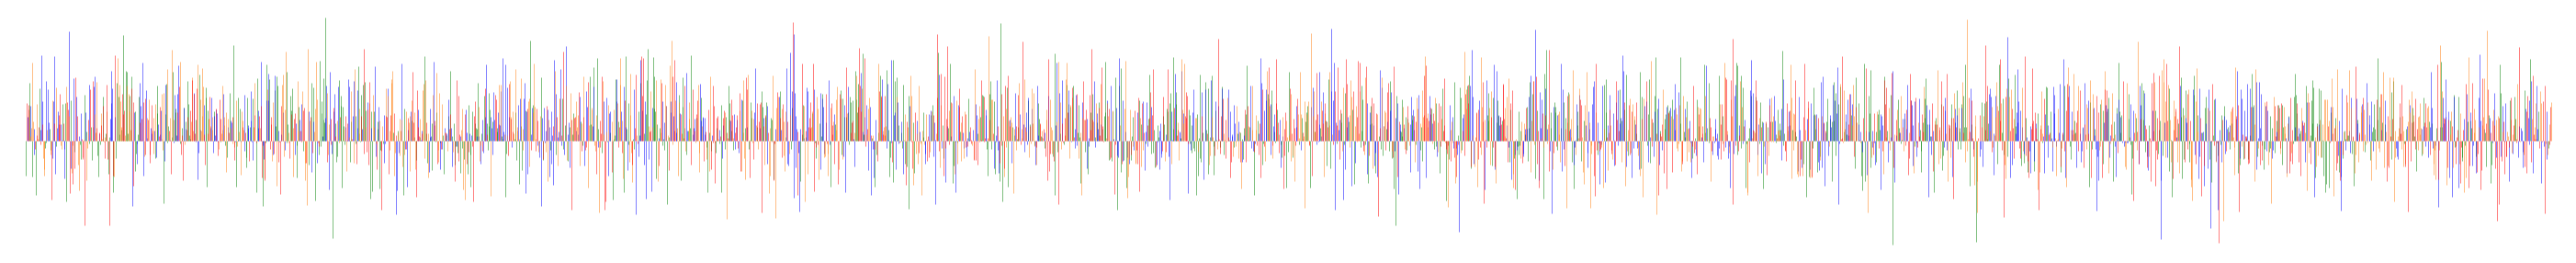

In [ ]:
mpl.rcParams['lines.linewidth'] = 0.5
mini_logo(random_seq.numpy(), figsize=(50,5), stem_alpha=1)
plt.axis('off')
plt.show()

In [ ]:
display_dict = {'7:105416560:C:A:R:wC': 'chr7:105776015  105776214',
                '7:27717716:G:C:R:wC': 'chr7:27677998  27678197'}


In [ ]:
for parent_id, lift_pos in display_dict.items():
    start, stop = lift_pos.split(':')[1].split('  ')
    start, stop = int(start), int(stop)
    extended_start = start - 4900
    extended_stop = stop + 4900
    print(f'chr7:{extended_start}-{extended_stop}')

chr7:105771115-105781114
chr7:27673098-27683097


In [ ]:
#fasta_file_name = '/content/drive/MyDrive/data/Genome_contributions/chr7-27675098-27681097.txt'
fasta_file_name = '/content/drive/MyDrive/data/Genome_contributions/chr7-27673098-27683097.txt'

num_lines = sum(1 for line in open(fasta_file_name,'r'))

fasta_dict = {}
with open(fasta_file_name, 'r') as f:
    for line in tqdm(f, total=num_lines):
        line_str = str(line)
        if line_str[0] == '>':
            my_id = line_str.lstrip('>').rstrip('\n')
            fasta_dict[my_id] = ''
        else:
            fasta_dict[my_id] += line_str.rstrip('\n')
seq_str = list(fasta_dict.values())[0]

  0%|          | 0/201 [00:00<?, ?it/s]

In [ ]:
contrib_bw = pyBigWig.open('contrib__chr7__K562.bw')

In [ ]:
seq_contributions =  dna2tensor(seq_str) * torch.Tensor(contrib_bw.values('chr7', 27673097, 27683097))

In [ ]:
27673097 + 4000

27677097

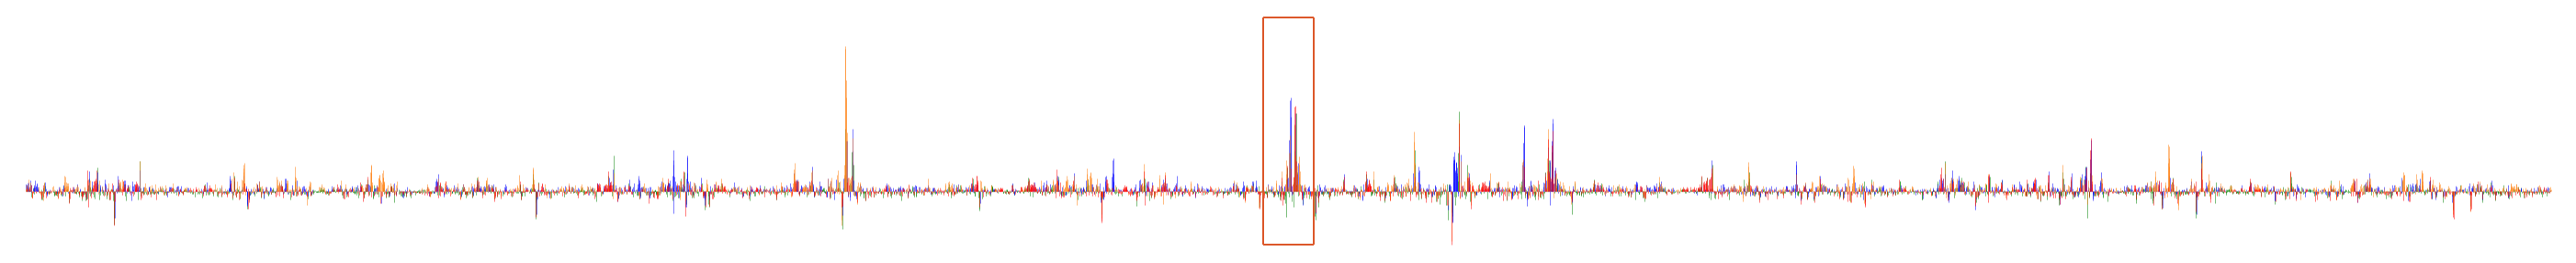

In [ ]:
color = '#DC582A' #'#002D72'

mpl.rcParams['lines.linewidth'] = 0.5
mini_logo(seq_contributions.numpy(), figsize=(50,5), stem_alpha=1)
plt.vlines(4900, -0.25, 0.8, color=color, linewidth=2, linestyles='solid')
plt.vlines(5100, -0.25, 0.8, color=color, linewidth=2, linestyles='solid')
plt.hlines(-0.25, 4900, 5100, color=color, linewidth=2, linestyles='solid')
plt.hlines(0.8, 4900, 5100, color=color, linewidth=2, linestyles='solid')
plt.axis('off')
plt.savefig('temp.pdf', format='pdf', transparent=True, dpi=300, bbox_inches='tight')
plt.show()

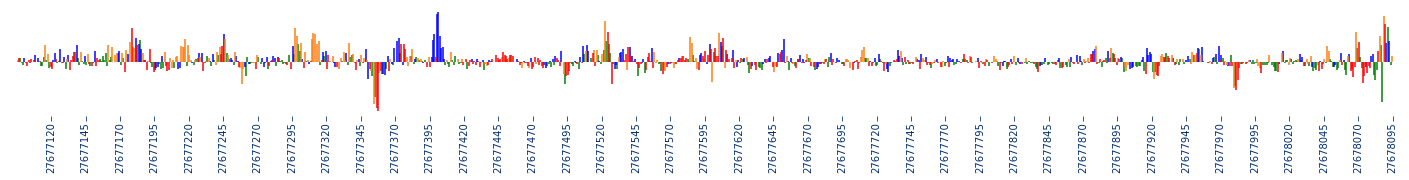

In [ ]:
window_contributions = seq_contributions[:, 4000:5000]

mpl.rcParams['lines.linewidth'] = 1.5
_, ax = mini_logo(window_contributions.numpy(), figsize=(25,2), stem_alpha=1)
# plt.vlines(2900, 0, 0.5)
# plt.vlines(3100, 0, 0.5)
#plt.axis('off')
start_tick = 27677096
ticks = np.arange(24, 1000, 25) + 0.5
tick_labels = np.arange(start_tick + 24, start_tick + 1000, 25)
plt.xticks(ticks, labels=tick_labels, rotation=90, color='#002D72')
ax.tick_params(axis='x', which='major', pad=1, length=5, colors='#002D72')#, labelbottom=False, labeltop=True)
ax.axes.get_yaxis().set_visible(False)
ax.spines['left'].set_visible(False)
# plt.xticks(ticks, labels=tick_labels, rotation=90, color='#002D72')
#plt.xticks(np.arange(24,1000, 25)+0.5, labels=np.arange(24,1000, 25)+1)

plt.savefig('temp.pdf', format='pdf', transparent=True, dpi=200, bbox_inches='tight')
plt.show()

In [ ]:
torch.

0.1514892578125

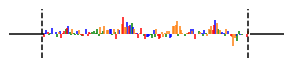

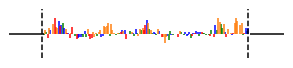

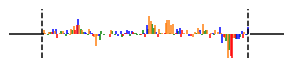

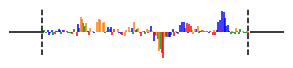

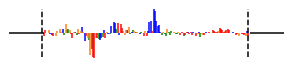

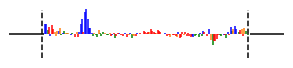

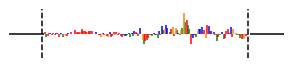

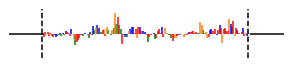

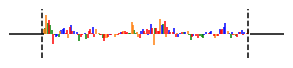

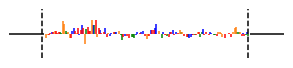

In [ ]:
window_contributions = seq_contributions[:, 4000:5000]
y_max, y_min = window_contributions.max().item(), window_contributions.min().item()
for i in range(0, 500, 50):
    mpl.rcParams['lines.linewidth'] = 1.5
    subwindow_contributions = window_contributions[:, i:i+200].clone()
    subwindow_contributions = subwindow_contributions + subwindow_contributions * torch.normal(mean=0, std=0.075, size=(1,200))
    subwindow_contributions[:, :25] = 0.0
    subwindow_contributions[:, 175:] = 0.0
    _, ax = mini_logo(subwindow_contributions.numpy(), figsize=(5,1), stem_alpha=1)
    plt.vlines(24, y_min, y_max, linestyle='dashed', color='black')
    plt.vlines(174, y_min, y_max, linestyle='dashed', color='black')
    plt.hlines(0, 0, 25, color='black')
    plt.hlines(0, 175, 200, color='black')
    plt.axis('off')
    # start_tick = 27677096
    # ticks = np.arange(24, 1000, 25) + 0.5
    # tick_labels = np.arange(start_tick + 24, start_tick + 1000, 25)
    # plt.xticks(ticks, labels=tick_labels, rotation=90, color='#002D72')
    # ax.tick_params(axis='x', which='major', pad=1, length=5, colors='#002D72', labelbottom=False, labeltop=True)
    # ax.axes.get_yaxis().set_visible(False)
    # ax.spines['left'].set_visible(False)
    #plt.savefig('temp.pdf', format='pdf', transparent=True, dpi=200, bbox_inches='tight')
    plt.show()

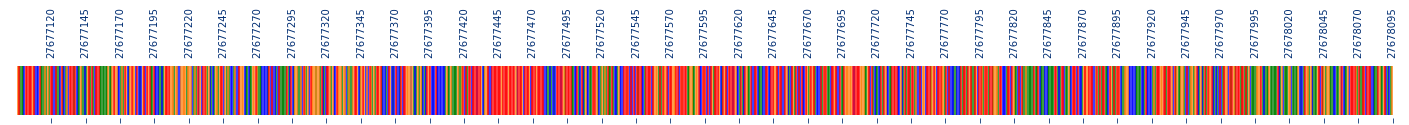

In [ ]:
window_onehot = 0.1 * (window_contributions != 0)

mpl.rcParams['lines.linewidth'] = 1.5
_, ax = mini_logo(window_onehot.numpy(), figsize=(25,1), stem_alpha=1)
# plt.vlines(2900, 0, 0.5)
# plt.vlines(3100, 0, 0.5)
#plt.axis('off')
start_tick = 27677096
ticks = np.arange(24, 1000, 25) + 0.5
tick_labels = np.arange(start_tick + 24, start_tick + 1000, 25)
plt.xticks(ticks, labels=tick_labels, rotation=90, color='#002D72')
ax.tick_params(axis='x', which='major', pad=1, length=5, colors='#002D72', labelbottom=False, labeltop=True)
ax.axes.get_yaxis().set_visible(False)
ax.spines['left'].set_visible(False)
#plt.savefig('temp.pdf', format='pdf', transparent=True, dpi=200, bbox_inches='tight')
plt.show()

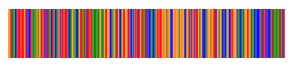

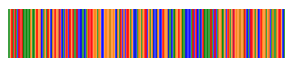

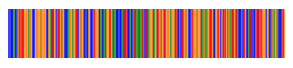

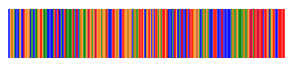

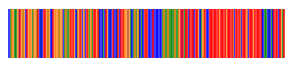

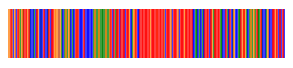

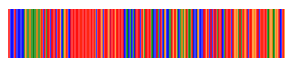

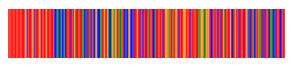

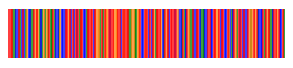

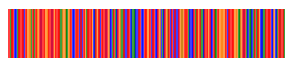

In [ ]:
for i in range(0, 500, 50):
    mpl.rcParams['lines.linewidth'] = 1.5
    subwindow_onehot = window_onehot[:, i:i+200]
    _, ax = mini_logo(subwindow_onehot.numpy(), figsize=(5,1), stem_alpha=1)
    # plt.vlines(2900, 0, 0.5)
    # plt.vlines(3100, 0, 0.5)
    plt.axis('off')
    # start_tick = 27677096
    # ticks = np.arange(24, 1000, 25) + 0.5
    # tick_labels = np.arange(start_tick + 24, start_tick + 1000, 25)
    # plt.xticks(ticks, labels=tick_labels, rotation=90, color='#002D72')
    # ax.tick_params(axis='x', which='major', pad=1, length=5, colors='#002D72', labelbottom=False, labeltop=True)
    # ax.axes.get_yaxis().set_visible(False)
    # ax.spines['left'].set_visible(False)
    #plt.savefig('temp.pdf', format='pdf', transparent=True, dpi=200, bbox_inches='tight')
    plt.show()

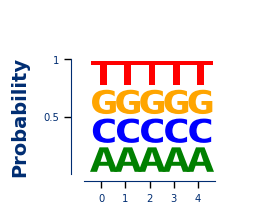

In [ ]:
seq_contributions = 0.25*torch.ones(4,5)

with plt.style.context('default'):
    mpl.rc('axes',edgecolor='#002D72')
    y_max = 1
    fig, ax = matrix_to_dms(seq_contributions, y_max=y_max, fontaspect=0.5, widthscale=0.8, axisfontscale=0.6, heightscale=0.6)
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 5))
    #ax.spines['bottom'].set_visible(False)
    #plt.axis('off')
    plt.xticks(np.arange(0.5, seq_contributions.shape[1] + 0.5), labels=np.arange(0, seq_contributions.shape[1]), color='#002D72')
    plt.yticks([0.5, 1], labels=[0.5, 1], color='#002D72')
    # plt.yticks([0, 0.5],  fontsize=12)
    plt.xlabel('')
    plt.ylim(0,1)
    plt.ylabel('Probability', fontsize=14, color='#002D72', labelpad=10, weight='bold')
    # plt.savefig('temp.pdf', format='pdf', transparent=True, dpi=300, bbox_inches='tight')
    plt.show()

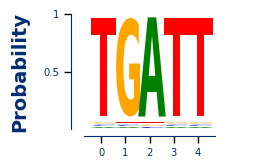

In [ ]:
seq_contributions = dna2tensor('TGATT')
seq_contributions = 0.98 * seq_contributions + 0.02 * torch.logical_not(seq_contributions)

with plt.style.context('default'):
    mpl.rc('axes',edgecolor='#002D72')
    y_max = 1
    fig, ax = matrix_to_dms(seq_contributions, y_max=y_max, fontaspect=0.5, widthscale=0.8, axisfontscale=0.6, heightscale=0.6)
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 5))
    #ax.spines['bottom'].set_visible(False)
    #plt.axis('off')
    plt.xticks(np.arange(0.5, seq_contributions.shape[1] + 0.5), labels=np.arange(0, seq_contributions.shape[1]), color='#002D72')
    plt.yticks([0.5, 1], labels=[0.5, 1], color='#002D72')
    # plt.yticks([0, 0.5],  fontsize=12)
    plt.xlabel('')
    plt.ylim(0,1)
    plt.ylabel('Probability', fontsize=14, color='#002D72', labelpad=10, weight='bold')
    # plt.savefig('temp.pdf', format='pdf', transparent=True, dpi=300, bbox_inches='tight')
    plt.show()

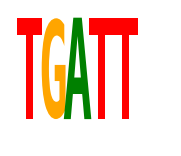

In [ ]:
seq_contributions = dna2tensor('TGATT')
#seq_contributions = 0.7 * seq_contributions + 0.28 * torch.logical_not(seq_contributions)

with plt.style.context('default'):
    mpl.rc('axes',edgecolor='#002D72')
    y_max = 1
    fig, ax = matrix_to_dms(seq_contributions, y_max=y_max, fontaspect=0.5, widthscale=0.8, axisfontscale=0.6, heightscale=0.6)
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 5))
    #ax.spines['bottom'].set_visible(False)
    #plt.axis('off')
    plt.xticks(np.arange(0.5, seq_contributions.shape[1] + 0.5), labels=np.arange(0, seq_contributions.shape[1]), color='#002D72')
    plt.yticks([0.5, 1], labels=[0.5, 1], color='#002D72')
    # plt.yticks([0, 0.5],  fontsize=12)
    plt.xlabel('')
    plt.ylim(0,1)
    plt.ylabel('Probability', fontsize=14, color='#002D72', labelpad=10, weight='bold')
    plt.axis('off')
    plt.savefig('temp.pdf', format='pdf', transparent=True, dpi=300, bbox_inches='tight')

    plt.show()

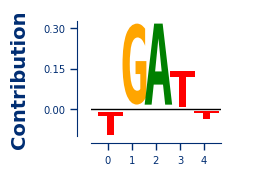

In [ ]:
# seq_contributions = dna2tensor('TGATT')
# seq_contributions = torch.normal(mean=0.2, std=0.2, size=(1,5)) * seq_contributions

with plt.style.context('default'):
    mpl.rc('axes',edgecolor='#002D72')
    y_max = seq_contributions.max()
    fig, ax = matrix_to_dms(seq_contributions, y_max=y_max, fontaspect=0.5, widthscale=0.8, axisfontscale=0.6, heightscale=0.6)
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 5))
    ax.tick_params(axis='both', colors='#002D72')
    #ax.spines['bottom'].set_visible(False)
    #plt.axis('off')
    plt.xticks(np.arange(0.5, seq_contributions.shape[1] + 0.5), labels=np.arange(0, seq_contributions.shape[1]), color='#002D72')
    # plt.yticks([0.5, 1], labels=[0.5, 1], color='#002D72')
    # plt.yticks([0, 0.5],  fontsize=12)
    plt.xlabel('')
    #plt.ylim(0,1)
    plt.ylabel('Contribution', fontsize=14, color='#002D72', labelpad=10, weight='bold')
    plt.savefig('temp.pdf', format='pdf', transparent=True, dpi=300, bbox_inches='tight')
    plt.show()